In [1]:
# pip install "exoplanet[pymc]"
# Downloaded already on my computer. get it at your leisure. 


In [2]:
# pip install -U "exoplanet[extras]"
# Downloaded already on my computer. get it at your leisure. 


In [3]:
# pip install --upgrade setuptools wheel


In [4]:
import numpy as np
print(np.__version__)


1.26.0


In [5]:
import exoplanet

exoplanet.utils.docs_setup()
print(f"exoplanet.__version__ = '{exoplanet.__version__}'")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


exoplanet.__version__ = '0.6.0'


In [6]:
# pip install numpy --upgrade
# problem with this. got dependency issues with exoplanet 

In [7]:
# !pip install numpy==1.26.0
# This was installed. works with exoplanet dependencies

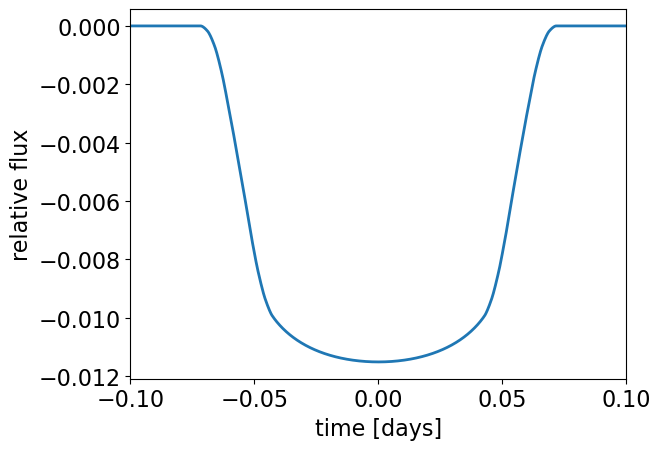

In [8]:

import numpy as np

import matplotlib.pyplot as plt

import exoplanet as xo

# The light curve calculation requires an orbit
orbit = xo.orbits.KeplerianOrbit(period=3.456)

# Compute a limb-darkened light curve using starry
t = np.linspace(-0.1, 0.1, 1000)
u = [0.3, 0.2]
light_curve = (
    xo.LimbDarkLightCurve(*u)
    .get_light_curve(orbit=orbit, r=0.1, t=t, texp=0.02)
    .eval()
)
# Note: the `eval` is needed because this is using Theano in
# the background

plt.plot(t, light_curve, color="C0", lw=2)
plt.ylabel("relative flux")
plt.xlabel("time [days]")
_ = plt.xlim(t.min(), t.max())


Do still ahve the extras? 
numpy 1.26.0 yes

astropy 6.1.0 yes

pymc 5.16.2 yes

exoplanet-core No. Its extra but... we'll see if it's actually extrequired 

Citation stuff
https://docs.exoplanet.codes/en/latest/tutorials/citation/

In [11]:
import pymc as pm
import exoplanet as xo

with pm.Model() as model:
    u = xo.distributions.quad_limb_dark("u")
    orbit = xo.orbits.KeplerianOrbit(period=10.0)
    light_curve = xo.LimbDarkLightCurve(u[0], u[1])
    transit = light_curve.get_light_curve(r=0.1, orbit=orbit, t=[0.0, 0.1])

    txt, bib = xo.citations.get_citations_for_model()

In [12]:
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet:joss,
exoplanet:zenodo} and its dependencies \citep{exoplanet:agol20,
exoplanet:arviz, exoplanet:astropy13, exoplanet:astropy18, exoplanet:kipping13,
exoplanet:luger18}.


Radial vel fitting. Working off Iliga's 

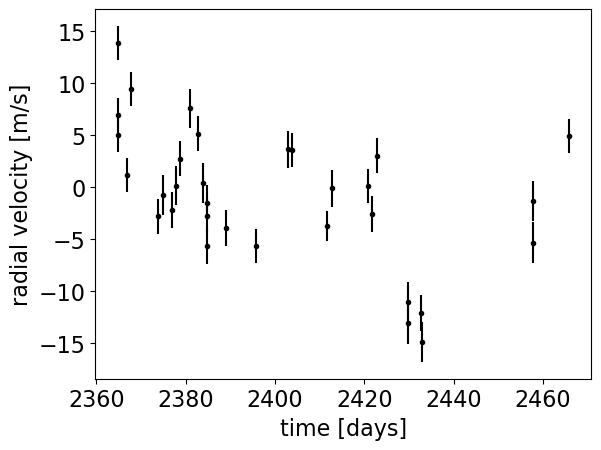

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/California-Planet-Search/radvel/master/example_data/epic203771098.csv"
data = pd.read_csv(url, index_col=0)

x = np.array(data.t)
y = np.array(data.vel)
yerr = np.array(data.errvel)

# Compute a reference time that will be used to normalize the trends model
x_ref = 0.5 * (x.min() + x.max())

# Also make a fine grid that spans the observation window for plotting purposes
t = np.linspace(x.min() - 5, x.max() + 5, 1000)

plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.xlabel("time [days]")
_ = plt.ylabel("radial velocity [m/s]")


In [15]:
import exoplanet as xo

periods = [20.8851, 42.3633]
period_errs = [0.0003, 0.0006]
t0s = [2072.7948, 2082.6251]
t0_errs = [0.0007, 0.0004]
Ks = xo.estimate_semi_amplitude(periods, x, y, yerr, t0s=t0s)
print(Ks, "m/s")

[5.05069163 5.50983542] m/s


In [16]:
0.5 * (
    np.log(np.array(periods) + np.array(period_errs))
    - np.log(np.array(periods) - np.array(period_errs))
)

array([1.43643076e-05, 1.41632026e-05])

In [17]:
np.array(period_errs) / np.array(periods)

array([1.43643076e-05, 1.41632026e-05])

In [18]:
import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt

with pm.Model() as model:
    # Gaussian priors based on transit data (from Petigura et al.)
    t0 = pm.Normal("t0", mu=np.array(t0s), sd=np.array(t0_errs), shape=2)
    logP = pm.Normal(
        "logP",
        mu=np.log(periods),
        sd=np.array(period_errs) / np.array(periods),
        shape=2,
        testval=np.log(periods),
    )
    P = pm.Deterministic("P", tt.exp(logP))

    # Wide log-normal prior for semi-amplitude
    logK = pm.Normal(
        "logK", mu=np.log(Ks), sd=2.0, shape=2, testval=np.log(Ks)
    )

    # Eccentricity & argument of periasteron
    ecs = pmx.UnitDisk("ecs", shape=(2, 2), testval=0.01 * np.ones((2, 2)))
    ecc = pm.Deterministic("ecc", tt.sum(ecs**2, axis=0))
    omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
    xo.eccentricity.vaneylen19(
        "ecc_prior", multi=True, shape=2, fixed=True, observed=ecc
    )

    # Jitter & a quadratic RV trend
    logs = pm.Normal("logs", mu=np.log(np.median(yerr)), sd=5.0)
    trend = pm.Normal("trend", mu=0, sd=10.0 ** -np.arange(3)[::-1], shape=3)

    # Then we define the orbit
    orbit = xo.orbits.KeplerianOrbit(period=P, t0=t0, ecc=ecc, omega=omega)

    # And a function for computing the full RV model
    def get_rv_model(t, name=""):
        # First the RVs induced by the planets
        vrad = orbit.get_radial_velocity(t, K=tt.exp(logK))
        pm.Deterministic("vrad" + name, vrad)

        # Define the background model
        A = np.vander(t - x_ref, 3)
        bkg = pm.Deterministic("bkg" + name, tt.dot(A, trend))

        # Sum over planets and add the background to get the full model
        return pm.Deterministic("rv_model" + name, tt.sum(vrad, axis=-1) + bkg)

    # Define the RVs at the observed times
    rv_model = get_rv_model(x)

    # Also define the model on a fine grid as computed above (for plotting)
    rv_model_pred = get_rv_model(t, name="_pred")

    # Finally add in the observation model. This next line adds a new contribution
    # to the log probability of the PyMC3 model
    err = tt.sqrt(yerr**2 + tt.exp(2 * logs))
    pm.Normal("obs", mu=rv_model, sd=err, observed=y)


ModuleNotFoundError: No module named 'pymc3'

I have a problem with pymc3. I downloaded pymc and got the verions below but when I try to download pymc3 i get errors in the instal

(base) C:\Users\Brian>conda list pymc
# packages in environment at D:\Users\Brian\anaconda3:
#
# Name                    Version                   Build  Channel
pymc                      5.16.2                   pypi_0    pypi
pymc-base                 5.17.0             pyhd8ed1ab_0    conda-forge
pymc-ext                  1.0.1                    pypi_0    pypi

(base) C:\Users\Brian>conda install -c conda-forge exoplanet numpy=1.19